Develop an XGBoost model in AWS to predict the Stock Price and deploy it using API.
==============

# I) Build and train an Amazon SageMaker model

## I.1) Create a S3 Bucket

Use boto3. It is an AWS software development kit (SDK) for python which allows to directly create, update and delete aws resources from a Python environment. It enables the easy integration of various Python application, library, script with AWS services including Amazon S3, Amazon DynamoDB, Amazon EC2, etc...

In [147]:
# Import the package
import boto3
import time

# Assign the resource we want to use - in this case "s3"
s3 = boto3.resource('s3')

# print the name of all available buckets in my s3 account.
for bucket in s3.buckets.all():
    print(bucket.name)

sagemaker-studio-396913707640-axxlnw5zdgi
sagemaker-us-east-1-396913707640
stockpricetest-1736740588
stockpricetest-1736741958
stockpricetest-1736741960


In [148]:
## Functions to automate tasks - still to integrate working with modules. 

def create_s3_bucket(base_name, unikey = int( 1736741958 ) ):  #unikey could be int(time.time())
    """
    Creates an S3 bucket with a unique name by appending a timestamp.

    Parameters:
        base_name (str): Base name for the bucket.

    Returns:
        str: The name of the created bucket or an error message.
    """
    # Generate a unique bucket name
    bucket_name = f"{base_name}-{unikey}"
    
    # Create the S3 client
    s3 = boto3.resource('s3')
    
    try:
        # Create the bucket
        s3.create_bucket(
            Bucket=bucket_name   )
        print(f"S3 bucket '{bucket_name}' has been created successfully.")
        return bucket_name
    except Exception as e:
        print(f"S3 error: {e}")
        return None

def flatten_columns(df):
    """
    Flattens a MultiIndex DataFrame to a single-level column index.

    Parameters:
    df (pd.DataFrame): The input DataFrame with MultiIndex columns.

    Returns:
    pd.DataFrame: DataFrame with single-level column index.
    """
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    return df

def drop_unimportant_features(df, columns_to_drop):
    """
    Drops specified columns from the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns_to_drop (list): List of column names to drop.

    Returns:
    pd.DataFrame: DataFrame with specified columns removed.
    """
    df.drop(columns=columns_to_drop, axis=1, inplace=True)
    return df

def move_column_to_first(df, column_name):
    """
    Moves a specified column to the first position in the DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to move.

    Returns:
    pd.DataFrame: DataFrame with the specified column moved to the first position.
    """
    first_column = df.pop(column_name)
    df.insert(0, column_name, first_column)
    return df


In [149]:
# Give the bucket a unique name as no user can have the same bucket name globally
# Note: the bucket name should be between 3 and 63 characters long, always start with a lower letters, cannot contain underscode
# More info here https://docs.aws.amazon.com/workdocs/latest/userguide/client-name-files.html 
# Note that you can also create the bucket manually through the Amazon S3 tool. 
buck_name = 'stockpricetest'
bucket_name = create_s3_bucket( base_name = buck_name, unikey = int( 1736741960 ) )

S3 bucket 'stockpricetest-1736741960' has been created successfully.


## I.2) Data Extract, Load & Transform
Download data from the yfinance package which is not installed in boto3

In [167]:
#!pip install yfinance

import pandas as pd
from datetime import datetime
import yfinance as yf

# initialise parameters
start_date = datetime( 2019, 1, 1)
end_date = datetime( 2021, 1, 1)

# get the data 
df_data = yf.download( 'AAPL', start = start_date, end = end_date)
df_data.reset_index(inplace = True)

df_data

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2019-01-02,37.708595,37.930665,36.827486,36.985083,148158800
1,2019-01-03,33.952534,34.795437,33.907164,34.379953,365248800
2,2019-01-04,35.401951,35.471200,34.336981,34.511292,234428400
3,2019-01-07,35.323162,35.538069,34.838433,35.507026,219111200
4,2019-01-08,35.996529,36.252028,35.464044,35.712376,164101200
...,...,...,...,...,...,...
500,2020-12-24,129.047501,130.504510,128.196772,128.411901,54930100
501,2020-12-28,133.663025,134.298625,130.553438,131.022819,124486200
502,2020-12-29,131.883270,135.716459,131.365008,134.992856,121047300


Carry out data cleaning & transformation. 

The columns of the data have multiIndices due to column labels Price and Ticker. There is a main title for the column and a subtitle as well. Run "df_data.columns" to see the structure of the MultiIndex. 

In [168]:
print(df_data.columns)

# Use the function flatten_columns to flatten the MultiIndex to work with a single-level column index. 
df_data = flatten_columns(df_data)
print(df_data.columns)

# Use the function drop_unimportant_features to drop features that are not important for this tutorial as they do not influence the stock price much
df_data = drop_unimportant_features(df_data, ['Date_'])
print(df_data.columns)

# Extract the features
df_data_features = df_data.iloc[ :-1, :]  # This excludes the last sample from the data to consider the remaining as our features. 
print( df_data_features )

# Take the open price column as our target 
df_data_targets = df_data.iloc[ 1:, 3].rename( "Targets" )
print( df_data_targets )

# Combine: assign the target column in the first column to satisfy XGBoost requirement
df_data_features[ 'Target' ] =  list( df_data_targets )
first_column = df_data_features.pop( 'Target' )
df_data_features.insert( 0, 'Target', first_column)

df_data_final = df_data_features
df_data_final

MultiIndex([(  'Date',     ''),
            ( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Index(['Date_', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL'],
      dtype='object')
Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='object')
     Close_AAPL   High_AAPL    Low_AAPL   Open_AAPL  Volume_AAPL
0     37.708595   37.930665   36.827486   36.985083    148158800
1     33.952534   34.795437   33.907164   34.379953    365248800
2     35.401951   35.471200   34.336981   34.511292    234428400
3     35.323162   35.538069   34.838433   35.507026    219111200
4     35.996529   36.252028   35.464044   35.712376    164101200
..          ...         ...         ...         ...          ...
499  128.059906  129.497339  127.883884  129.233329     88223700
500  129.047501  130.504510  128.196772  128.

/tmp/ipykernel_18365/3810022124.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_features[ 'Target' ] =  list( df_data_targets )


,Target,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
0,34.379953,37.708595,37.930665,36.827486,36.985083,148158800
1,34.511292,33.952534,34.795437,33.907164,34.379953,365248800
2,35.507026,35.401951,35.471200,34.336981,34.511292,234428400
3,35.712376,35.323162,35.538069,34.838433,35.507026,219111200
4,36.125461,35.996529,36.252028,35.464044,35.712376,164101200
...,...,...,...,...,...,...
499,128.411901,128.059906,129.497339,127.883884,129.233329,88223700
500,131.022819,129.047501,130.504510,128.196772,128.411901,54930100
501,134.992856,133.663025,134.298625,130.553438,131.022819,124486200
502,132.577585,131.883270,135.716459,131.365008,134.992856,121047300


### Randomply split the data into the training and test data

In [169]:
# Import the necessary package
import numpy as np

# Shuffle the rows to make the split random
df_randomised = df_data_final.sample(frac = 1, random_state = 123)
df_randomised

# split the data randomly
train_data, test_data = np.split( df_randomised, [int(0.8 * len(df_randomised))] )
print(train_data.shape, test_data.shape)


(403, 6) (101, 6)


### Set a path and upload dataset to S3 bucket

In [170]:
import os

# set file name base
prefix = 'xgboost-as-a-built-in-algo'

# set the path
train_csv_path = 's3://{}/{}/{}/{}'.format(bucket_name, prefix, 'train', 'train.csv')  # The empty bracket set the space for each element in (bucket_name, prefix, 'train', 'train.csv')
test_csv_path = 's3://{}/{}/{}/{}'.format(bucket_name, prefix, 'test', 'test.csv')

print(train_csv_path)
print(test_csv_path)

# Save to S3 bucket
train_data.to_csv(train_csv_path, index = False, header = False)
test_data.to_csv(test_csv_path, index = False, header = False)

# If you get a warning saying that "Your installed version of s3fs is very old and known to cause severe performance issues"
# upgrade your s3fs as follows to solve the issue: '!pip install --upgrade s3fs'

s3://stockpricetest-1736741960/xgboost-as-a-built-in-algo/train/train.csv
s3://stockpricetest-1736741960/xgboost-as-a-built-in-algo/test/test.csv


## I.3) Build the XGBoost model

XGBoost is a popular and efficient open-source implementation of the gradient-boosted trees algorithm. Gradient boosting is a supervised learning algorithm that tries to predict a target variable accurately by combining multiple estimates from a set of simpler models. 

There are two ways to use XGBoost in Amazon SageMaker AI, either 
* as a built-in algorithm that simplifies the process of training and deploying models through the use of a pre-built Docker container and a high-level SageMaker abstraction such as the Estimator class (similar to using a wrapper function). This requires minimal setup and is performed on SagemAker's infrastructure either on CPUs or GPUSs depending on the instance type selected. 
* or as a framework to run your custom training scripts developed on your local environments which SageMaker runs inside a containerised environment on its infrastructure. Here you control the training process, thus being more flexible. 



In [171]:
# Import required packages
import sagemaker
from sagemaker import image_uris
from sagemaker.session import Session 
from sagemaker.inputs import TrainingInput

### Find the XGBoost image URI and build and XGBoost container
More information about XGBoost in Amazon SageMaker can be found here https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html. 

As part of this tutorial, we use XGBoost as a Built-in algorithm. 

In [172]:
xgboost_container = image_uris.retrieve("xgboost", boto3.Session().region_name, "1.2-2")
display(xgboost_container)

[01/15/25 05:14:43] INFO     Ignoring unnecessary instance type: None.                            ]8;id=663131;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=795118;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#528\528]8;;\

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-2'

### Initialise Hyperparameters

##### Booster Parameters
These are parameters that influence the prediction performance of the model
* **max_depth** - Maximum depth of a tree. A larger number makes the model more complex and might lead to model overfitting.
* **eta** - Step size shrinkage used in updates or optimisation to prevent overfitting.
* **gamma** - Minimum loss reduction required to make a further partition on a leaf node of the tree.
* **min_child_weight** - Minimum sum of instance weight needed in a child. If the tree participation step results in a leaf node. 
* **subsample** - Subsample ratio of the training instances. A value of 0.5 means that XGBoost randomly collects half of the data instances to grow trees. This prevents overfitting. 

##### Learning task parameters
**objective:** parameter which allows practitioners to specify the learning task and the corresponding learning objective. 


In [173]:
hyperparameters = {
    "max_depth" : "5",
    "eta" : "0.2",
    "gamma" : "4",
    "min_child_weight" : "6",
    "subsample" : "0.7",
    "objective" : "reg:squarederror",
    "early_stopping_rounds" : 10,
    "num_round" : 1000
}

#### Set an output path where the trained model would be saved
Note that: 
* the first, **{}** is the bucket name
* the second, **{}** is the prefix 
* and the last, **{}** is the output folder

In [174]:
output_path = 's3://{}/{}/{}/'.format(bucket_name, prefix, 'output')

print( output_path )

s3://stockpricetest-1736741960/xgboost-as-a-built-in-algo/output/


#### Construct a SageMaker estimator that calls the XGBoost container

Enable the spot instance argument **use_spot_instances**. A Spot Instance is an Amazon EC2 instance that uses spare computing capacity in AWS's data centers. They are available at significantly reduced costs (up to 90% cheaper than On-Demand instances)


In [175]:
estimator = sagemaker.estimator.Estimator( image_uri = xgboost_container, 
                                          hyperparameters = hyperparameters,
                                          role = sagemaker.get_execution_role(), 
                                          instance_count = 1,
                                          instance_type = 'ml.m4.xlarge',  # surpisingly I could run with this instance type even though I select a different instance type when creating the notebook instance. 
                                          volume_size = 5,  # 5 GB
                                          output_path = output_path,
                                          use_spot_instances = True,   # Enable the use_spot_instances constructor arg
                                          max_run = 300,               #timeout in secons for the model training
                                          max_wait = 600,              # amount of time you are willing to wait for Spot infrastructure to become available
                                         )

#### Define the data type and paths to the training and validation datasets
specify the paths where the training and test data should be taken from. 

In [176]:
content_type = "csv"
train_input = TrainingInput( "s3://{}/{}/{}/".format(bucket_name, prefix, 'train'), content_type = content_type)
test_input = TrainingInput( "s3://{}/{}/{}/".format(bucket_name, prefix, 'test'), content_type = content_type)

#### Execute the XGBoost training job


In [177]:
estimator.fit( {'train' : train_input, 'validation' : test_input} )

[01/15/25 05:14:53] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=836932;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=811530;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=505065;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=15059;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-01-15-05-14-53-360                                             

2025-01-15 05:14:55 Starting - Starting the training job......
..25-01-15 05:15:29 Starting - Preparing the instances for training.
..25-01-15 05:16:24 Downloading - Downloading input data.
........15 05:16:55 Downloading - Downloading the training image.
2025-01-15 05:18:26 Training - Training image download completed. Training in progress.
2025-01-15 05:18:26 Uploading - Uploading generated training model[2025-01-15 05:18:18.482 ip-10-0-155-71.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-01-15:05:18:18:INFO] Imported framework sagemaker_xgboost_container.training
[2025-01-15:05:18:18:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2025-01-15:05:18:18:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-15:05:18:18:INFO] Running XGBoost Sagemaker in algorithm mode
[2025-01-15:05:18:18:INFO] Determined delimiter of CSV input is ','
[2025-01-15:05:18:18:INFO] Determined delimiter of CSV inp

# II) Deploy and test the Amazon SageMaker model endpoint

## II.1) Deploy trained XGB model as Endpoint

1. Environment
i.e. in which environment do we want to make the predictions or inferences? 
> Within SageMaker - then do Serialization by User <br>
> **Outside SageMaker - Serialization by Endpoint**

2. Method to invoke the endpoint
i.e. how do we want to invoke the Endpoint?
> **Through an API - suitable for a single prediction using the Amazon API Gateway** <br>
> Through a S3 Bucket - suitable for Batch prediction

4. Data type based on method
i.e. what data type format should we use to invoke the Endpoint? In other words, in which file format should the unseen data be saved to invoke the EndPoint? 
> **API - JSON** is suitable when the prediction is done outside of SageMaker - invoked by a customer request. <br>
> S3 Bucket - CSV - invoked internally by the practitioner. 

To host and deploy the trained model, estimator, fitted earlier, through Amazon EC2 using Amazon SageMaker, we call the **deploy** method of the **xgb_model estimator**.

A few things need to be specified when you call the deploy method: 
> **initial_instance_count (int)** - The number of instances to deploy the model <br>

> **instance_type (str)** - The type of instances or computational power that you want to operate your deployed model. <br>

> **serializer (int)** - Serialize input data of various formats (a numpy array, list, file, or buffer) to a CSV-formatted string. We use this because the XGBoost algorithm accepts input files in CSV format




References: 

https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html <br>
https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-model-deployment.html 

In [204]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = estimator.deploy( initial_instance_count = 1, instance_type = 'ml.m4.xlarge', serializer = CSVSerializer() )  

# We use CSVSerializer because our model was trained using csv format training data. Thus the CSVSerializer will convert any data provided by teh customer into CSV format

[01/15/25 06:01:59] INFO     Creating model with name: sagemaker-xgboost-2025-01-15-06-01-59-668    ]8;id=85512;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=292983;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[01/15/25 06:02:00] INFO     Creating endpoint-config with name                                     ]8;id=179623;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=765531;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\
                             sagemaker-xgboost-2025-01-15-06-01-59-668                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-01-15-06-01-59-668  ]8;id=934256;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=590091;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

----------!

In [205]:
# See the Endpoint name
xgb_predictor.endpoint_name

name = 'sagemaker-xgboost-2025-01-15-06-01-59-668'

'sagemaker-xgboost-2025-01-15-06-01-59-668'

## II.2) Make prediction with the use of Endpoint

In [230]:
# initialise parameters 
start_date = datetime( 2021, 1, 4)
end_date = datetime(2021, 1, 5)

# get the data
df_data = yf.download( 'AAPL', start = start_date, end = end_date)
df_data.reset_index(inplace = True)
print( df_data )



[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open     Volume
Ticker                   AAPL        AAPL        AAPL        AAPL       AAPL
0      2021-01-04  126.544205  130.651192  123.952888  130.563189  143301900
1      2021-01-05  128.108765  128.822609  125.585897  126.035717   97664900
2      2021-01-06  123.796440  128.147899  123.581311  124.891640  155088000
3      2021-01-07  128.020782  128.715066  125.028548  125.517476  109578200


#### Prepare the data features

In [213]:
# Use the function "flatten_columns" to flatten the MultiIndex to work with a single-level column index. 
df_data = flatten_columns(df_data)

# use the function "drop_unimportant_features" to drop features that are not important. 
df_data = drop_unimportant_features(df_data, ['Date_'])

print( df_data ) 

# extract the feature array
data_features_array = df_data.values
print(data_features_array)

   Close_AAPL   High_AAPL   Low_AAPL   Open_AAPL  Volume_AAPL
0  126.544228  130.651216  123.95291  130.563213    143301900
[[1.26544228e+02 1.30651216e+02 1.23952910e+02 1.30563213e+02
  1.43301900e+08]]


#### Serialise the data

##### Inference - Serialised input SageMaker Function

There is no need to serialize the feature arrays as the serializer was specified when creating the endpoint for deployment. 

In [208]:
Y_pred_Fcn = xgb_predictor.predict( data_features_array ).decode('utf-8')  # decode('utf-8') convert from bytes to string data type
print( Y_pred_Fcn, type(Y_pred_Fcn) ) 

128.8832550048828
 <class 'str'>


##### Inference - Serialised Input by built-in function (Lambda function friendly)
Serialise the input using another method. 

In [210]:
Input = [[126.544228, 130.651216, 123.95291, 130.563213, 143301900],
         [126.544228, 130.651216, 123.95291, 130.563213, 143301900],
         [126.544228, 130.651216, 123.95291, 130.563213, 143301900]]

serialized_input = ','.join(map(str, Input[0]))

print( serialized_input, type(serialized_input) ) 

Y_pred = xgb_predictor.predict( serialized_input ).decode('utf-8')  # decode('utf-8') convert from bytes to string data type
print( Y_pred, type(Y_pred) ) 

126.544228,130.651216,123.95291,130.563213,143301900 <class 'str'>
128.8832550048828
 <class 'str'>


#### Inference - Create an AWS Lambda function (Base)

How to build and set up the Lambda function in the AWS environment to connect to the endpoint and serve the customer. 

##### What is AWS lambda
AWS Lambda is a serverless computing service provided by Amazon Web Services (AWS). It enables users to run code without provisioning or managing servers. With AWS Lambda, you write and upload your code as functions, which are then executed in response to specific triggers or events from other AWS services (e.g. API Gateway). The code can be run from any application or backend service. 

In a nutshell, the AWS Lambda function allows a seamless interaction between the Endpoint we created and the customer via an API Gateway. The lambda function takes the request from the customer via the API Gateway, and then invokes our backend services (Endpoint) to provide an appropriate response to the customer. 

Key Features of AWS Lambda include: 
> **Event-Driven Execution**: Lambda functions can be triggered by various AWS services such as S3 (object uploads), DynamoDB (data changes), API Gateway (HTTP requests), CloudWatch (scheduled events), and more. <br>

> **Serverless**: no need to manage servers or infrastructure; AWS handles the scaling, patching, and infrastructure management. <br>

> **Pay-as-You-Go**: you only pay for the time your code runs, measured in milliseconds, and for the number of requests made to your function. <br>

> **Automatic Scaling**: Lambda automatically scales your application by running as many instances of the function as needed to handle incoming events. <br>

> **Multiple Programming Languages**: Lambda supports several programming languages, including Python, Node.js, Java, Go, C#, and Ruby. You can also bring your own custom runtime. <br>

> **Integrated with AWS Services**: works seamlessly with AWS services such as S3, DynamoDB, API Gateway, CloudWatch, and others. <br>


https://docs.aws.amazon.com/lambda/latest/dg/welcome.html

##### How to work with AWS Lambda
You need a Lambda function handler which is available in various computer programming languages. for instance Python, Java, Ruby

The Lambda function handler is the method in your function code that processes events. When your function is invoked, Lambda runs the handler method. 

* **Step 1:**
  The AWS Lambda function stakes the order or request from the customer and converts it into a JSON format using the function handler.
  
  When AWS Lambda invokes your function handler, the Lambda runtime passes two arguments:
  > **Event Object**: A JSON-formatted document containing data for the Lambda function to process. The runtime converts this event into a Python object, typically a dictionary. But it can also be of type list, str, int, float, or NoneType. The event object structure depends on the invoking service or the manual invocation configuration. <br>
  
  > **Context Object**: This object provides runtime information about the function and invocation. It includes methods and properties that allow you to access details such as the function name, memory limit, and remaining execution time. In essence, Lambda functions process the event data provided by the triggering service and utilise the context for runtime and invocation metadata. <br> 

https://docs.aws.amazon.com/lambda/latest/dg/python-handler.html

* **Step 2:**
  The lambda handler function returns the response.

  > First, it serialize the input and invoke the SageMager Endpoint. <br>
  
  > Next, takes the output from the Endpoint and returns it as a response to the user's request.

  
  

#### Create a lambda function handler



In [239]:
import boto3

ENDPOINT_NAME = 'sagemaker-xgboost-2025-01-15-06-01-59-668'  # endpoint name created in previous steps
runtime = boto3.client( 'runtime.sagemaker')

# Define the function 

def lambda_handler(event, context):
    inputs = event['data']

    # Serialise the input - '\n' helps serialised multiple rows if any
    serialized_input = '\n'.join([','.join(map(str, row)) for row in inputs])

    # Call out the Endpoint - use SagemMaker runtime to invoke the Endpoint
    response = runtime.invoke_endpoint( EndpointName = ENDPOINT_NAME, 
                                       ContentType = 'text/csv', 
                                       Body = serialized_input
                                      )
    # Decode the response as it comes in bytes 
    result = response['Body'].read().decode()

    # Convert it to a list format
    result = [float(value) for value in result.strip().split('\n')]
    
    return result  # you can return {'response': response, 'result' : result} to see how the response looks. Note that a 'HTTPStatusCode' of 200 shows that the handler could establish a successful connection with the endpoint. 

In [240]:
# Create a testing json input
Input_json ={ 'data' :
             [[126.544228, 130.651216, 123.95291, 130.563213, 143301900],
             [128.108765, 128.822609, 125.585897, 126.035717, 97664900],
             [123.796440, 128.147899, 123.581311, 124.891640, 155088000] ]
       }

# Test the Lambda_handler function
result = lambda_handler(Input_json, None)  #There is no context information 
result

[128.8832550048828, 128.8832550048828, 124.11212158203125]

# Setup the Lamda function, then copy and paste this handler into that function. 
The handler will help us manage both the input and output. 

i) Go to the Lambda Console: https://us-east-1.console.aws.amazon.com/lambda/home?region=us-east-1#/begin

> * Click on Create Function <br>
> * Then "Author from Scratch" <br>
> * Define the name of the function: eg myFunction <br>
> * Select the Runtime: Python latest version <br>
> * Architecture: use default i.e. x86_64 <br>
> * Execution permissions: use either an existing or create a new role with basic lambda permissions. Choose the latter for practicality <br>
> * Finally Click on Create function


ii) Next, head to the IAM Console
> * Click on Role <br>
> * Then click on the role with Trusted entities - AWS Services: Lambda. We do not have SageMaker policies that allow us to have access to the endpoint using the created Lambda function. Thus we need to add the policies through this process. <br>
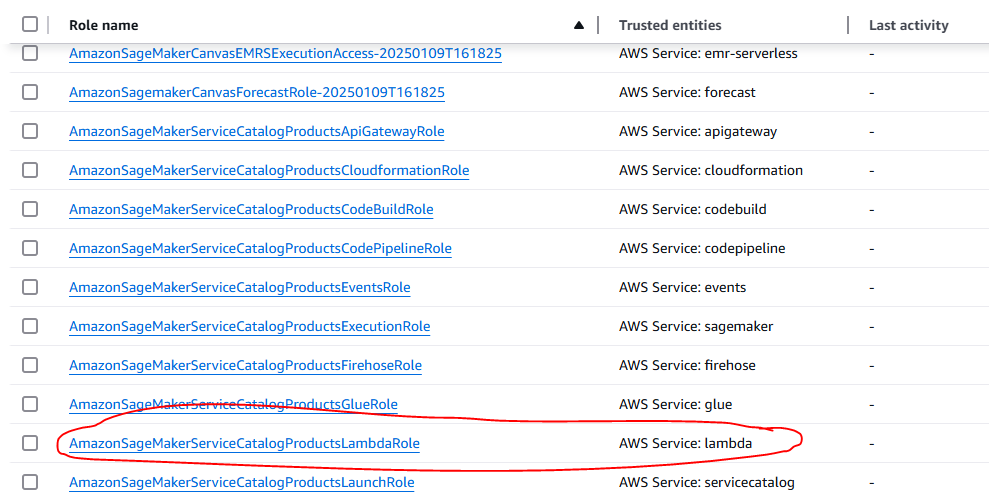
> * Next, click on Add Permissions -> Attach Policies <br>
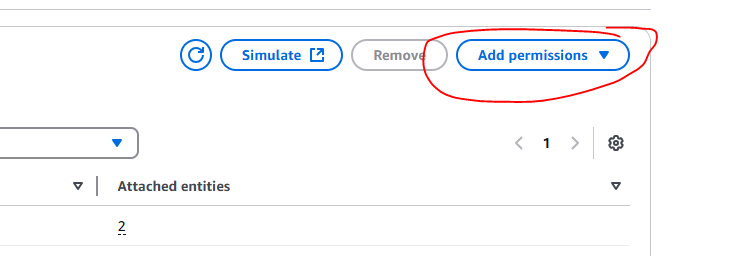
> * In the Search box type "AmazonSageMaker"
> * Then select the policy named "AmazonSageMakerCanvasFullAccess". This policy provides you with full access to Amazon SageMaker via the AWS Management Console and SDK - including Amazon Simple Storage Service (S3), RedShift, ECR, EC2, etc.... <br>  Select the policy via the select square and click on add permissions to attach the policy to the Lambda permissions. <br>
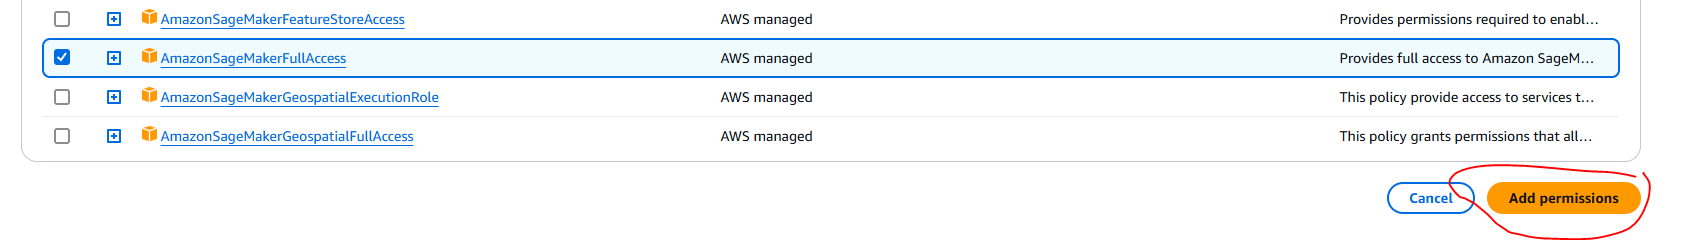


iii) Next, Head back to the Lambda Console add the earlier created Lambda_Handler and test 
> * Scroll down to the Code Source box, and replace the Lambda_function content with the lambda function handler we created earlier <br>
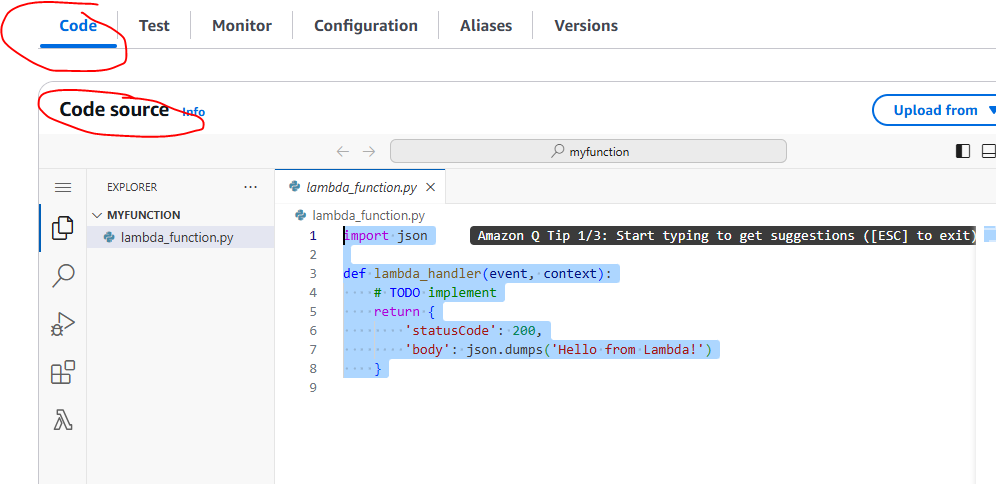
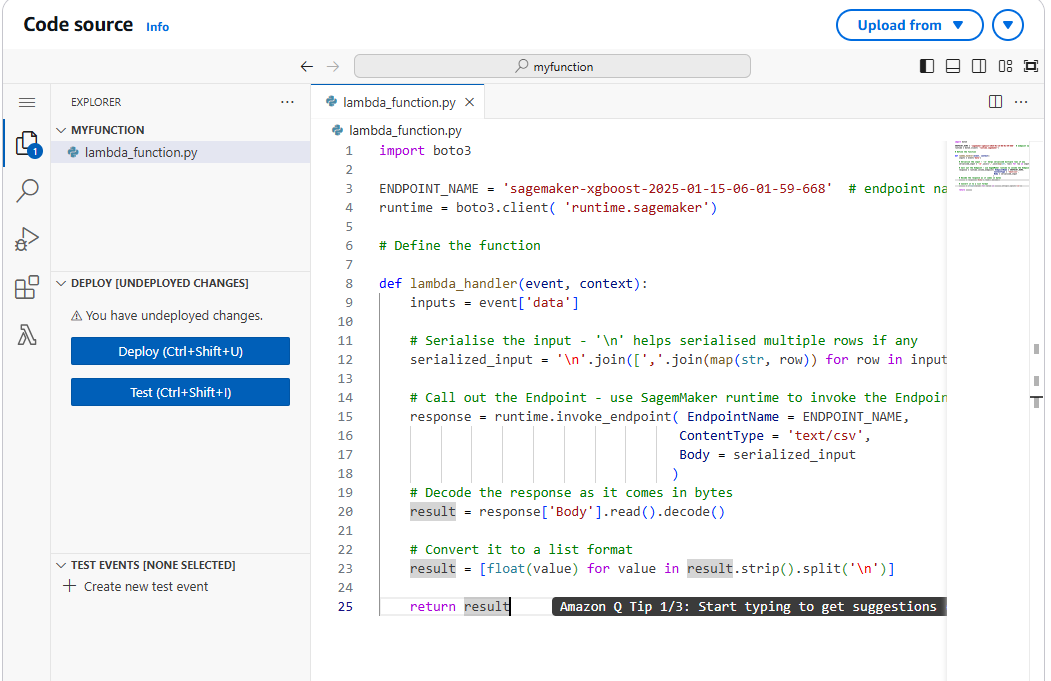
> * Click on Deploy - which will give a message "Succesfully updated the function myfunction".
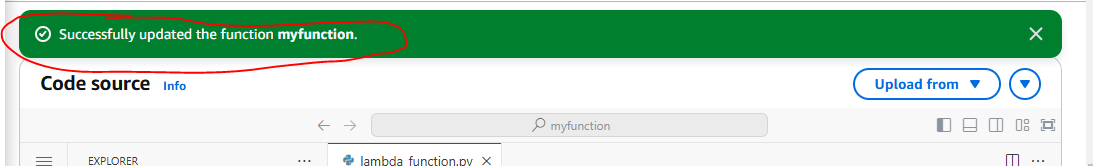
> * Then set a test event - Click on the Test tab and configure the test as on the image below:
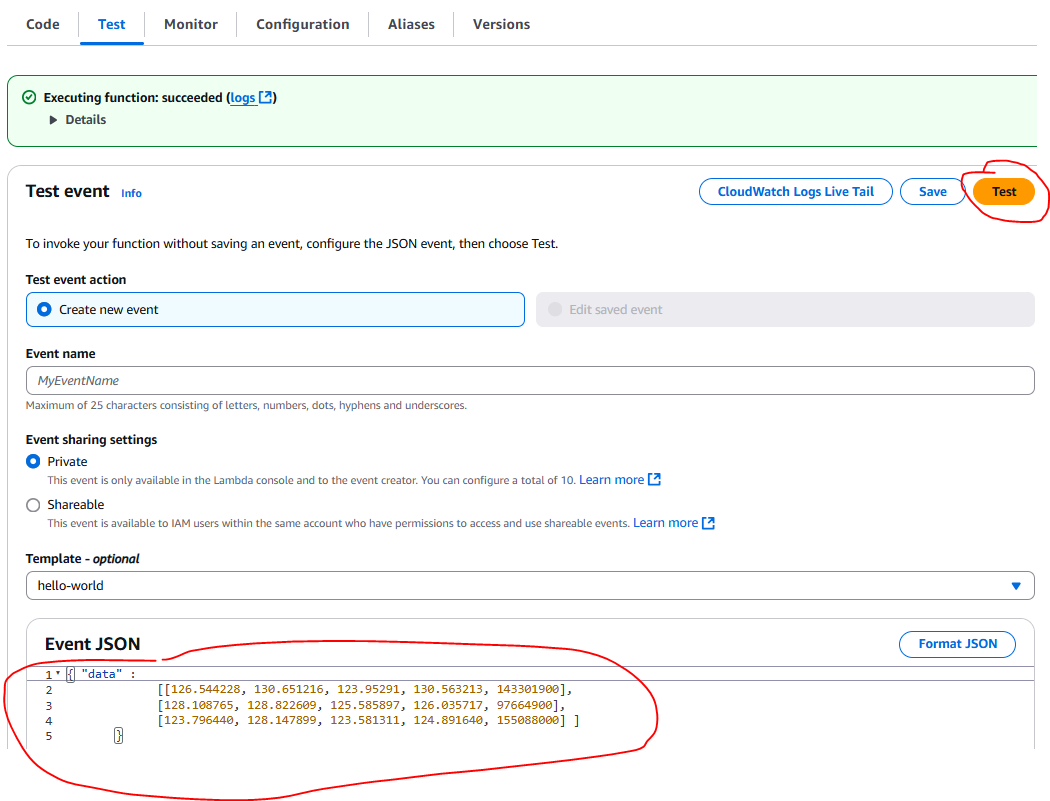
The test checks whether the lambda function successfully calls the Endpoint and returns the expected output. For this test the output is successful and the same as what we had earlier. 
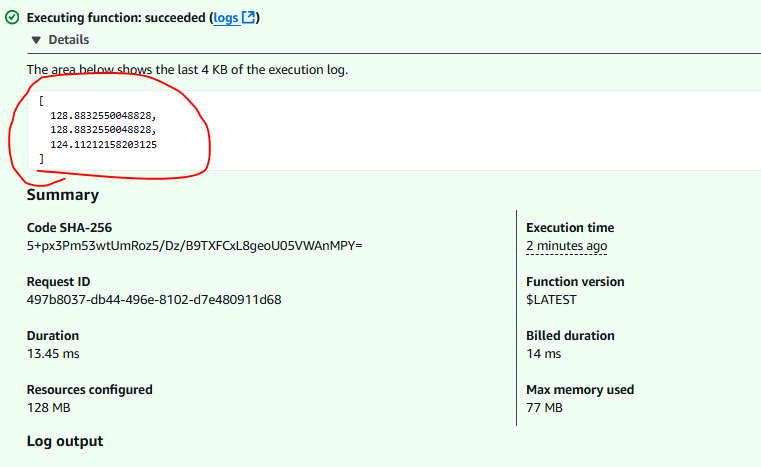

Now you can successfully create a Lambda function that takes the Json input, serialise it, invoke the SageMaker Endpoint and return the response. You also know how to set the Execution policy. Remember to make use of Amazon Q help to resolve any run failure. 


In [ ]:
# Extend the functionality of the Lambda function to trigger the SNS service
The aim of the SNS service is to send email notification to customers. 

